# **T 1.0: IMPORT LIBRARIES**

In [45]:
# importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D 
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import math
import time
import pickle
import json

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay, confusion_matrix, 
                             roc_auc_score, balanced_accuracy_score, f1_score, fbeta_score, 
                             accuracy_score, precision_score, recall_score, average_precision_score, 
                             precision_recall_curve, make_scorer)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, BaggingClassifier)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

# **T 1.1: EXPLORATORY DATA ANALYSIS**

Shape of the data= (215604, 223) 

           count        mean         std     min       25%       50%  \
p_x     215604.0  176.934871  102.491875  0.0000   88.0000  177.0000   
p_y     215604.0  303.167789  175.323061  0.0000  151.0000  303.0000   
Band_1  215604.0    0.095601    0.164291 -0.0120    0.0226    0.0378   
Band_2  215604.0    0.094335    0.163833 -0.0126    0.0206    0.0368   
Band_3  215604.0    0.095621    0.165067 -0.0119    0.0200    0.0377   

             75%       max  
p_x     266.0000  354.0000  
p_y     455.0000  607.0000  
Band_1    0.0780    1.5810  
Band_2    0.0780    1.5741  
Band_3    0.0811    1.5871  
number of nan values =  0
number of null values =  0
number of infinite values =  0




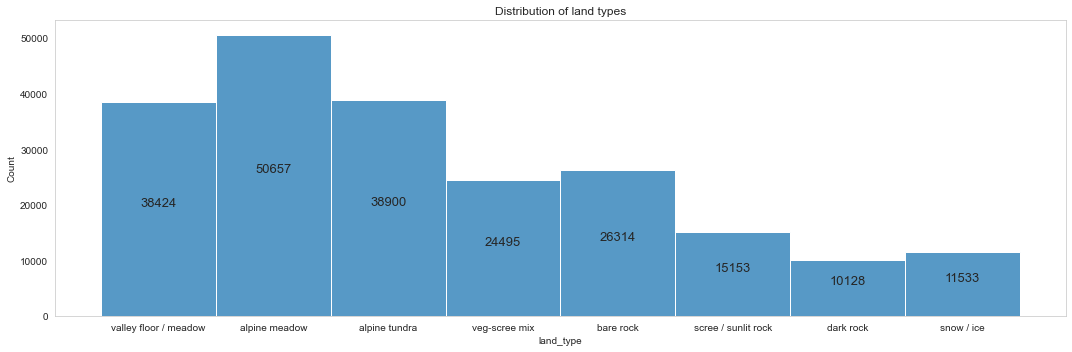

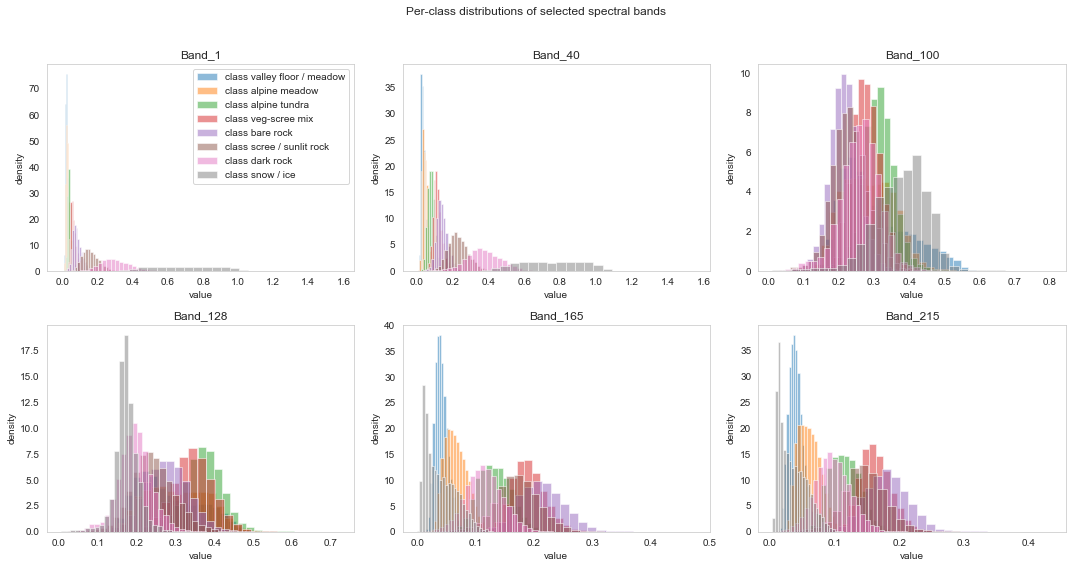

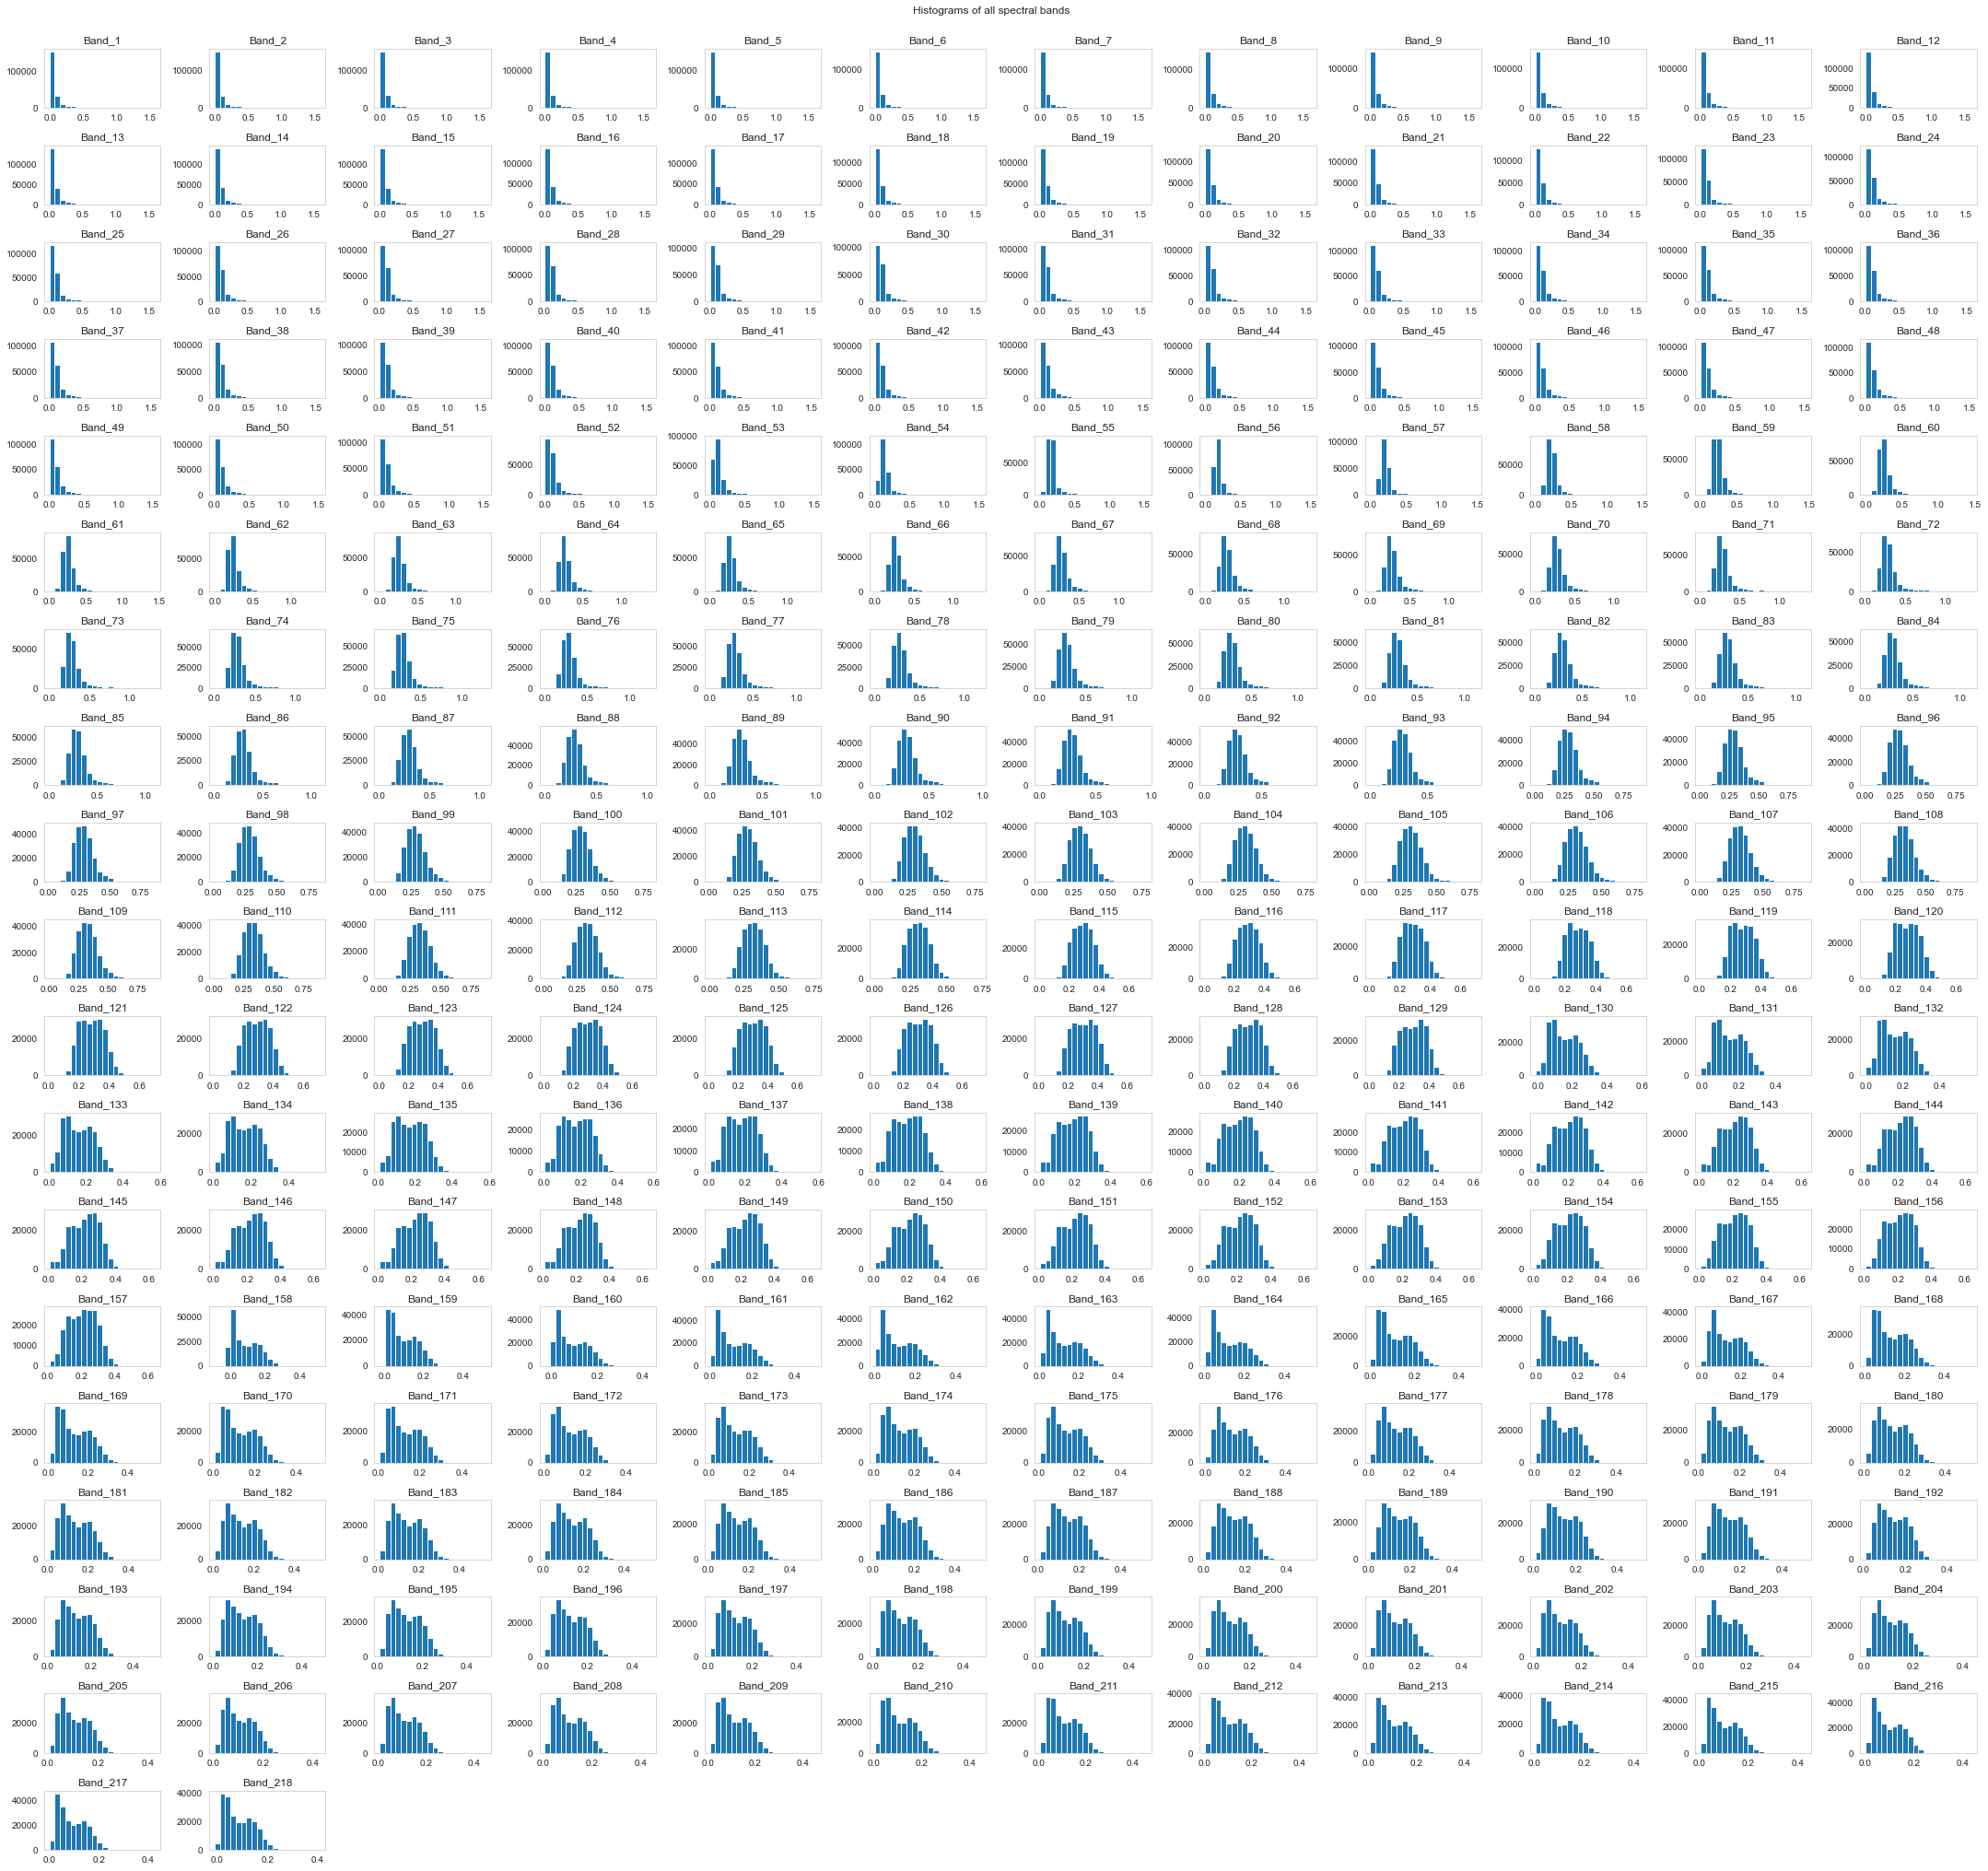

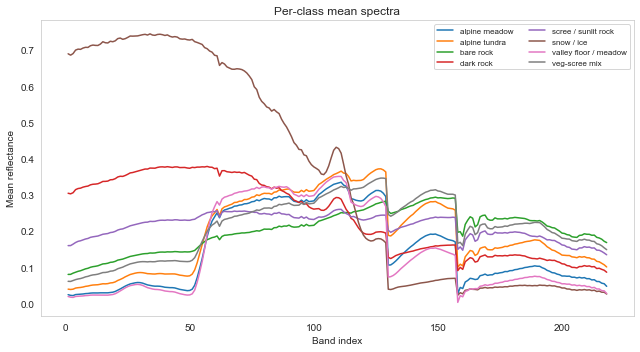

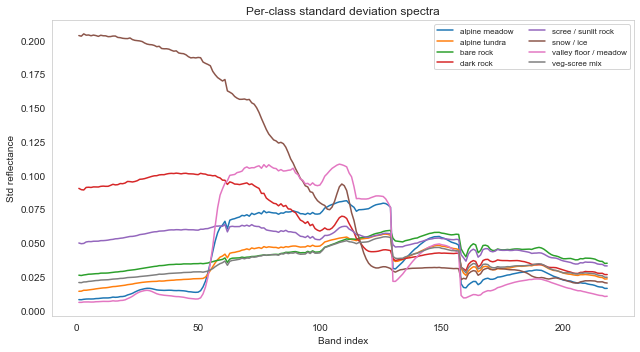

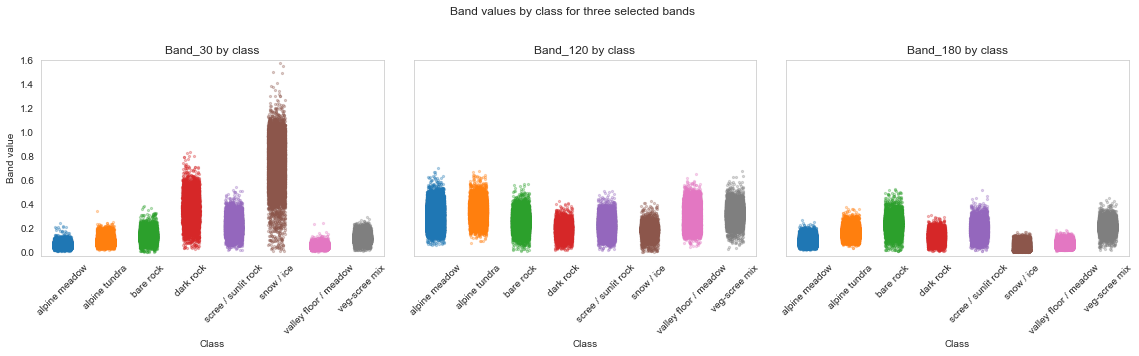

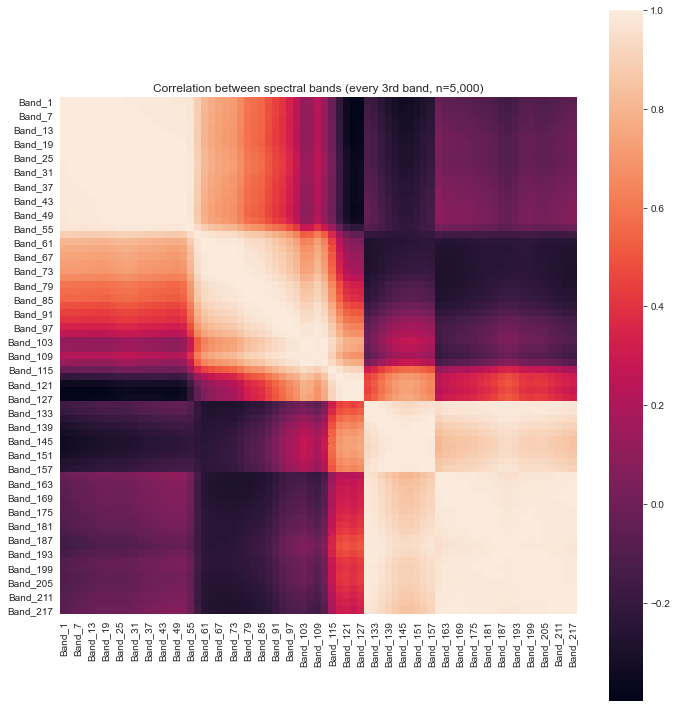

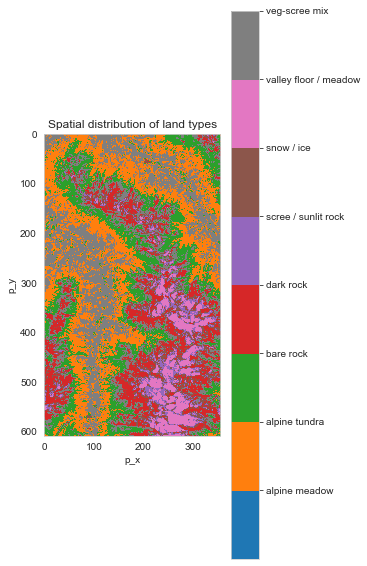

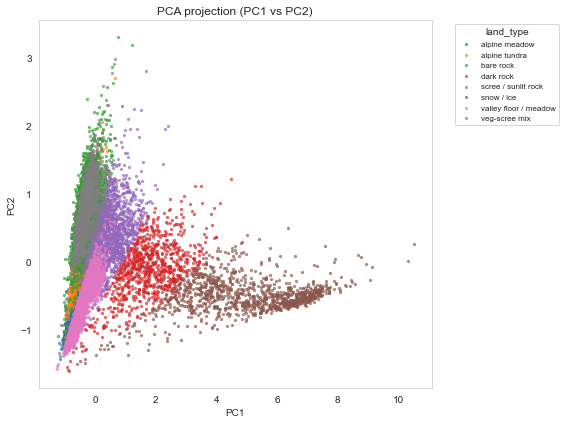

In [46]:
#reading the data
random_state = 24 # fix random state parameter to make all the result and metrics comparable with each other
df = pd.read_csv('data-1.csv.gz', compression='gzip')
print('Shape of the data=', df.shape, '\n')

band_cols = [c for c in df.columns if c.startswith("Band")]
df['land_type_cat'] = df['land_type'].astype('category').cat.codes

print(df.describe().T.head())


# infinite values, nan & null values, unneccessary features
print('number of nan values = ', df.isna().sum().sum())
print('number of null values = ', df.isnull().sum().sum())
print('number of infinite values = ', df[df == np.inf].count().sum())
print('\n')


# =============================================================================
# Figure 1. Distribution of land types (class balance)
# =============================================================================
plt.figure(figsize=(15, 5))
ax = sns.histplot(df['land_type'])

for p in ax.patches:
    count = p.get_height()
    ax.annotate(f'{int(count)}',
                (p.get_x() + p.get_width() / 2, count/2),
                ha='center', va='bottom', fontsize=13, rotation=0)

ax.set_title("Distribution of land types", fontsize=12)
ax.grid(False)

plt.tight_layout()
plt.savefig("1_eda_land_type_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()


# =============================================================================
# Figure 2. Per-class distributions of selected spectral bands
# =============================================================================
classes   = df['land_type'].unique()
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(['Band_1', 'Band_40', 'Band_100', 'Band_128', 'Band_165', 'Band_215']):
    ax = axes[i]
    for cls in classes:
        ax.hist(df.loc[df['land_type'] == cls, col],
                bins=30, density=True, alpha=0.5,
                label=f'class {cls}')
    ax.set_title(col)
    ax.set_xlabel('value')
    ax.set_ylabel('density')
    ax.grid(False)

axes[0].legend()
fig.suptitle("Per-class distributions of selected spectral bands", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig("2_eda_interclass_band_dists.pdf", dpi=300, bbox_inches="tight")
plt.show()


# =============================================================================
# Figure 3. Histograms of all spectral bands
# =============================================================================
axes_hist = df[band_cols].hist(bins=20, figsize=(30, 30), layout=(20, 12))
for ax_row in axes_hist:
    for ax in ax_row:
        ax.grid(False)
plt.suptitle("Histograms of all spectral bands", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("3_eda_all_bands_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()
print('\n')

# Per class mean spectrum
def sample_per_class(df, per_class=5000, seed=24):
    parts = []
    for k, sub in df.groupby('land_type', observed=True):
        parts.append(sub.sample(min(per_class, len(sub)), random_state=seed))
    return pd.concat(parts, axis=0)

samp = sample_per_class(df, per_class=5000)
means = samp.groupby('land_type', observed=True)[band_cols].mean()
stds  = samp.groupby('land_type', observed=True)[band_cols].std()

# =============================================================================
# Figure 4. Per-class mean spectra
# =============================================================================
plt.figure(figsize=(9,5))
for cls in means.index:
    plt.plot(range(1, len(band_cols)+1), means.loc[cls].values, label=str(cls))
plt.xlabel("Band index")
plt.ylabel("Mean reflectance")
plt.title("Per-class mean spectra")
plt.legend(ncol=2, fontsize=8)
plt.gca().grid(False)

plt.tight_layout()
plt.savefig("4_eda_mean_spectra_by_class.pdf", dpi=300, bbox_inches="tight")
plt.show()

# =============================================================================
# Figure 5. Per-class standard deviation spectra
# =============================================================================
plt.figure(figsize=(9,5))
for cls in stds.index:
    plt.plot(range(1, len(band_cols)+1), stds.loc[cls].values, label=str(cls))
plt.xlabel("Band index")
plt.ylabel("Std reflectance")
plt.title("Per-class standard deviation spectra")
plt.legend(ncol=2, fontsize=8)
plt.gca().grid(False)

plt.tight_layout()
plt.savefig("5_eda_std_spectra_by_class.pdf", dpi=300, bbox_inches="tight")
plt.show()


# =============================================================================
# Figure 6. Band values by class for three selected bands
# =============================================================================
bands = ["Band_30", "Band_120", "Band_180"]

target_col = "land_type" 

classes = np.sort(df["land_type"].unique())
n_classes = len(classes)

all_values = df[bands].values
y_min = all_values.min()
y_max = all_values.max()

margin = 0.02 * (y_max - y_min)
y_min_plot = y_min - margin
y_max_plot = y_max + margin

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, band in zip(axes, bands):
    for i, cls in enumerate(classes):
        vals = df.loc[df["land_type"] == cls, band].values
        jitter = np.random.uniform(-0.2, 0.2, size=len(vals))
        x_coords = np.full_like(vals, i, dtype=float) + jitter
        ax.scatter(x_coords, vals, alpha=0.3, s=5)
    
    ax.set_title(f"{band} by class")
    ax.set_xlabel("Class")
    ax.set_xticks(range(n_classes))
    ax.set_xticklabels(classes, rotation=45)

    ax.set_xlim(-0.5, n_classes - 0.5)
    ax.set_ylim(y_min_plot, y_max_plot)
    ax.grid(False)

axes[0].set_ylabel("Band value")
fig.suptitle("Band values by class for three selected bands", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig("6_eda_band_scatter_by_class.pdf", dpi=300, bbox_inches="tight")
plt.show()


# =============================================================================
# Figure 7. Correlation between spectral bands
# =============================================================================
sample_corr = df[band_cols[::3]].sample(5000, random_state=24)
corr = sample_corr.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cbar=True, square=True)
plt.title("Correlation between spectral bands (every 3rd band, n=5,000)")
plt.gca().grid(False)
plt.tight_layout()
plt.savefig("7_eda_band_correlation_heatmap.pdf", dpi=300, bbox_inches="tight")
plt.show()


# =============================================================================
# Figure 8. Spatial distribution of land types
# =============================================================================
from matplotlib.colors import ListedColormap

classes = df["land_type"].astype("category")
codes = classes.cat.codes
class_names = classes.cat.categories
palette = sns.color_palette("tab10", len(class_names))
class_color = dict(zip(class_names, palette))
cmap = ListedColormap(palette)

width = df["p_x"].max() + 1
height = df["p_y"].max() + 1

img = np.full((height, width), -1, dtype=int)
img[df["p_y"], df["p_x"]] = codes

plt.figure(figsize=(5, 8))
im = plt.imshow(img, cmap=cmap, origin="upper", interpolation="nearest")
plt.xlabel("p_x")
plt.ylabel("p_y")
plt.title("Spatial distribution of land types")
plt.gca().grid(False)

cbar = plt.colorbar(im, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)

plt.tight_layout()
plt.savefig("8_eda_spatial_land_types.pdf", dpi=300, bbox_inches="tight")
plt.show()

# =============================================================================
# Figure 9. PCA projections (3D – HTML, 2D – PDF)
# =============================================================================
# PCA (3 components)
sample = df.sample(20000, random_state=0) 
X = sample[band_cols] 
y = sample["land_type"] 

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# ---------- 3D Plotly PCA (только HTML, без PNG) ----------
pio.renderers.default = "notebook_connected"

df_pca = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "PC3": X_pca[:, 2],
    "land_type": y.values
})

fig_plotly = px.scatter_3d(
    df_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    color="land_type",
    opacity=0.6,
    width=800,
    height=600,
    title="Interactive PCA projection (3D)"
)
fig_plotly.show()

fig_plotly.write_html("pca_3d.html")

# ---------- 2D PCA (PC1 vs PC2) + сохранение PDF ----------
plt.figure(figsize=(8, 6))
ax2 = plt.gca()

classes_2d = np.sort(y.unique())
for cls in classes_2d:
    mask = (y == cls)
    ax2.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=5,
        alpha=0.6,
        label=str(cls)
    )

ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_title("PCA projection (PC1 vs PC2)")
ax2.grid(False)

ax2.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=8,
    title="land_type"
)

plt.tight_layout()
plt.savefig("9_pca_2d_pc1_pc2.pdf", dpi=300, bbox_inches="tight")
plt.show()

- Hyperspectral well-processed data (no empty or infimitely large values) with 215 604 observations and 218 features. The dataset contains 215604 observations, 218 spectral bands and 8 classes. Highly imbalanced classes. This should motivate the use of metrics robust to class imbalance.

- There is class "separability": In many bands the peaks and centers of the distributions for the classes are shifted: some classes are concentrated around smaller values, others around larger ones. Features actually carry information about the class, linear boundaries have a chance to work => LDA is worth trying

- Most bands have symmetrical, or slightly skewed distributions, which is in poor agreement with the assumption of normality.

- The features do not contain extreme noise distributions

- The classes differ greatly in the shape of their spectral curves => every class has its own unique features, so it will be simple for models to distinguish between classes <=> thus linear combinations of features exist and LDA, logreegression and SVM will provide quiet good results => Well-defined classes. Those lines that strongly coincide/overlap, which means that models with them will deviate more than with well-separated classes, i.e., this explains the errors in the confusion matrix.

- Classes with low variance spread will be predicted more accurately by models than classes with high variance spread within them. For LDA (equal variance for each class is important), it is clear that this model will clearly not be the best, since the variance spread is high. 

- The features are highly multicollinear => shows the need to do PCA

- We assume that samples are independent and that there is no obvious grouping structure (e.g. multiple measurements of the same physical object) that would require grouped cross-validation.

#### Overall, the EDA suggests that this is a feasible but non-trivial classification problem. Class imbalance requires stratified splitting and metrics such as macro-F1 or balanced accuracy. Spectral features are informative and allow for good class separability, but they are highly correlated and vary in scale, motivating the use of standardization and dimensionality reduction. Some classes are intrinsically harder to distinguish due to overlapping spectral patterns, which is consistent with the expected confusion patterns of the models.

# **T 1.2: TRAINING AND EVALUATION OF MULTICLASS CLASSIFIERS**

In [47]:
# Using only hyperspectral bands as features
X = df[band_cols].values #predictors 
y = df['land_type_cat'].values #dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

Model performance from test samlpe size

Model: LDA
  Size   1000: F1=0.8147, Time=0.0s, Overfit=0.1434
  Size   2000: F1=0.8407, Time=0.0s, Overfit=0.0785
  Size   5000: F1=0.8530, Time=0.1s, Overfit=0.0365
  Size  10000: F1=0.8571, Time=0.1s, Overfit=0.0207
  Size  15000: F1=0.8589, Time=0.1s, Overfit=0.0150
  Size  20000: F1=0.8593, Time=0.2s, Overfit=0.0142
  Size  30000: F1=0.8590, Time=0.3s, Overfit=0.0087
  Size  40000: F1=0.8589, Time=0.4s, Overfit=0.0076

Model: LDA+PCA
  Size   1000: F1=0.8397, Time=0.0s, Overfit=0.0024
  Size   2000: F1=0.8458, Time=0.0s, Overfit=-0.0067
  Size   5000: F1=0.8446, Time=0.0s, Overfit=-0.0105
  Size  10000: F1=0.8411, Time=0.1s, Overfit=-0.0039
  Size  15000: F1=0.8400, Time=0.1s, Overfit=-0.0044
  Size  20000: F1=0.8395, Time=0.1s, Overfit=-0.0027
  Size  30000: F1=0.8389, Time=0.2s, Overfit=-0.0023
  Size  40000: F1=0.8381, Time=0.2s, Overfit=-0.0004

Model: LogReg
  Size   1000: F1=0.9463, Time=0.6s, Overfit=0.0382
  Size   2000: F1=0.9662, 

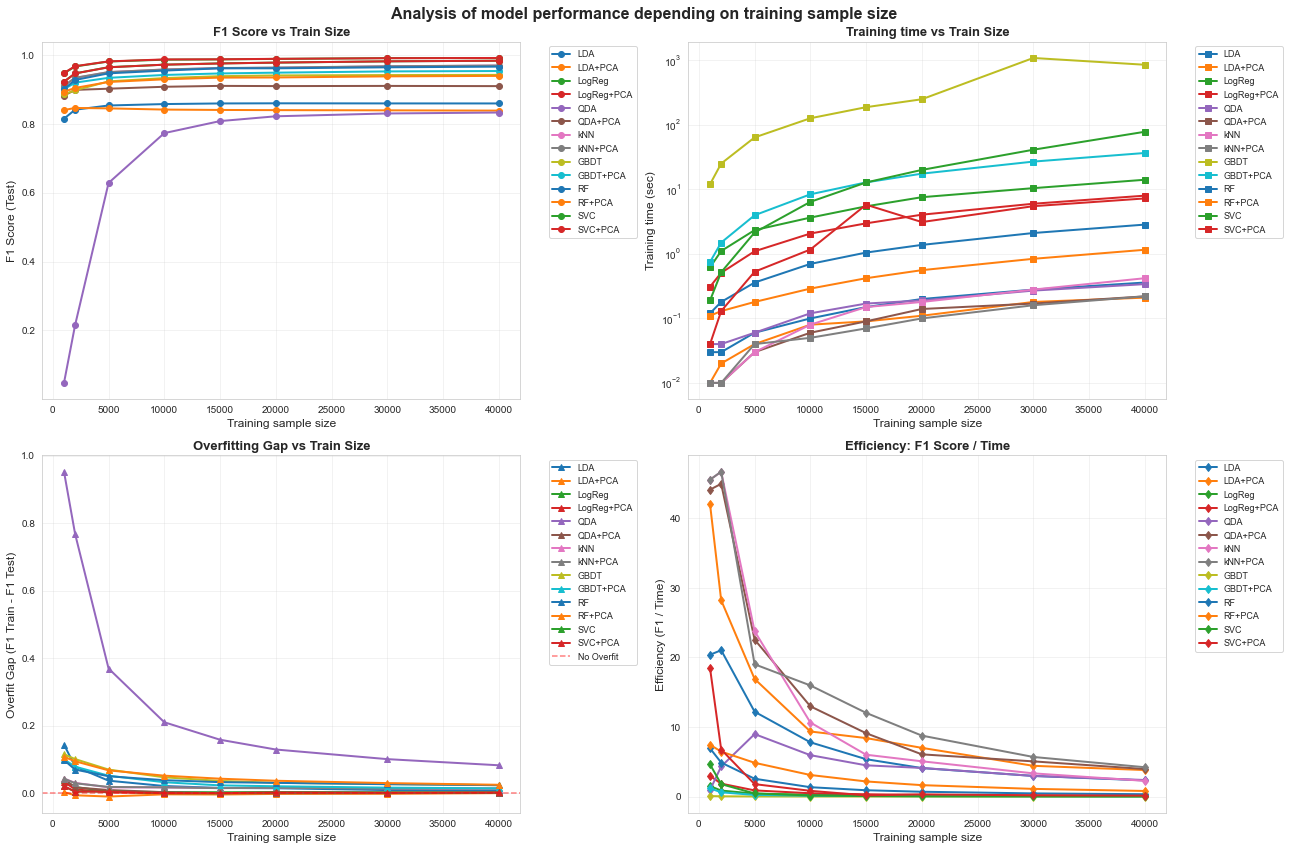


 Model performance plot is saved as 'model_performance_analysis.png'


In [48]:
# ====================================================================================================
#                     QUICK understanding of optimal train sample size: F1-score
# ====================================================================================================
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

def quick_performance_test(X_train, y_train, X_test, y_test, train_sizes, random_state=random_state):
    models = {
        'LDA': LinearDiscriminantAnalysis(solver='lsqr'),
        'LDA+PCA': make_pipeline(
            StandardScaler(),
            PCA(n_components=10, random_state=random_state),
            LinearDiscriminantAnalysis(solver='lsqr')),
        'LogReg': make_pipeline(
            StandardScaler(),
            LogisticRegression(C=1, max_iter=1000, random_state=random_state)),
        'LogReg+PCA': make_pipeline(
            StandardScaler(),
            PCA(n_components=10, random_state=random_state),
            LogisticRegression(C=1, max_iter=1000, random_state=random_state)),
        'QDA': QuadraticDiscriminantAnalysis(),
        'QDA+PCA': make_pipeline(
            StandardScaler(),
            PCA(n_components=10, random_state=random_state),
            QuadraticDiscriminantAnalysis()),
        'kNN': make_pipeline(
            StandardScaler(),
            KNeighborsClassifier(n_neighbors=5)),
        'kNN+PCA': make_pipeline(
            StandardScaler(),
            PCA(n_components=10, random_state=random_state),
            KNeighborsClassifier(n_neighbors=5)),
        'GBDT': GradientBoostingClassifier(
            n_estimators=50, 
            max_depth=3, 
            random_state=random_state),
        'GBDT+PCA': make_pipeline(
            StandardScaler(),
            PCA(n_components=10, random_state=random_state),
            GradientBoostingClassifier(
                n_estimators=50, 
                max_depth=3, 
                random_state=random_state)),
        'RF': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            class_weight='balanced',
            random_state=random_state,
            n_jobs=-1),
        'RF+PCA': make_pipeline(
            StandardScaler(),
            PCA(n_components=10, random_state=random_state),
            RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                class_weight='balanced',
                random_state=random_state,
                n_jobs=-1)),
        'SVC': make_pipeline(StandardScaler(),
                       SVC(decision_function_shape='ovo', 
                               probability=True)),
        'SVC+PCA': make_pipeline(StandardScaler(), PCA(n_components=10, random_state=random_state),
                       SVC(decision_function_shape='ovo', probability=True))
        }
    
    res = []
    
    available_train_sizes = [s for s in train_sizes if s <= len(X_train)]
    
    print("="*80)
    print("Model performance from test samlpe size")
    print("="*80)
    
    for model_name, model in models.items():
        print(f"\n{'='*40}")
        print(f"Model: {model_name}")
        print(f"{'='*40}")
        
        for train_size in available_train_sizes:
            
            #stratified subsampling
            X_sample, _, y_sample, _ = train_test_split(X_train, 
                                                        y_train, 
                                                        train_size=train_size, 
                                                        random_state=random_state,
                                                        stratify=y_train)
            try:
                # fittimg time
                t0 = time.time()
                model.fit(X_sample, y_sample)
                fit_time = time.time() - t0
                
                # predicting time
                t0 = time.time()
                y_pred = model.predict(X_test)
                pred_time = time.time() - t0
                
                f1 = f1_score(y_test, y_pred, average='macro')
                balanced_acc = balanced_accuracy_score(y_test, y_pred)
                
                # checking for overfitting
                y_train_pred = model.predict(X_sample)
                f1_train = f1_score(y_sample, y_train_pred, average='macro')
                overfit_gap = f1_train - f1
                
                res.append({
                    'Model': model_name,
                    'Train Size': train_size,
                    'Fit Time (s)': round(fit_time, 2),
                    'Pred Time (s)': round(pred_time, 2),
                    'F1 Train': round(f1_train, 4),
                    'F1 Test': round(f1, 4),
                    'Overfit Gap': round(overfit_gap, 4),
                    'Balanced Acc': round(balanced_acc, 4)
                })
                
                print(f"  Size {train_size:>6}: F1={f1:.4f}, Time={fit_time:.1f}s, Overfit={overfit_gap:.4f}")
                
            except Exception as e:
                print(f"  Size {train_size:>6}: ERROR - {str(e)}")
                continue
    
    return pd.DataFrame(res)

#vizualising the results
def plot_performance_analysis(df_results):
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Analysis of model performance depending on training sample size', fontsize=16, fontweight='bold')
    
    # 1. F1 Score Test vs Train Size
    ax1 = axes[0, 0]
    for model in df_results['Model'].unique():
        model_data = df_results[df_results['Model'] == model]
        ax1.plot(model_data['Train Size'], model_data['F1 Test'], marker='o', label=model, linewidth=2)
    ax1.set_xlabel('Training sample size', fontsize=12)
    ax1.set_ylabel('F1 Score (Test)', fontsize=12)
    ax1.set_title('F1 Score vs Train Size', fontsize=13, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # 2. Training time vs Train Size
    ax2 = axes[0, 1]
    for model in df_results['Model'].unique():
        model_data = df_results[df_results['Model'] == model]
        ax2.plot(model_data['Train Size'], model_data['Fit Time (s)'], marker='s', label=model, linewidth=2)
    ax2.set_xlabel('Training sample size', fontsize=12)
    ax2.set_ylabel('Training time (sec)', fontsize=12)
    ax2.set_title('Training time vs Train Size', fontsize=13, fontweight='bold')
    ax2.set_yscale('log')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # 3. Overfitting Gap vs Train Size
    ax3 = axes[1, 0]
    for model in df_results['Model'].unique():
        model_data = df_results[df_results['Model'] == model]
        ax3.plot(model_data['Train Size'], model_data['Overfit Gap'], marker='^', label=model, linewidth=2)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No Overfit')
    ax3.set_xlabel('Training sample size', fontsize=12)
    ax3.set_ylabel('Overfit Gap (F1 Train - F1 Test)', fontsize=12)
    ax3.set_title('Overfitting Gap vs Train Size', fontsize=13, fontweight='bold')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax3.grid(True, alpha=0.3)
    
    # 4. Efficiency: F1 Score / Time
    ax4 = axes[1, 1]
    for model in df_results['Model'].unique():
        model_data = df_results[df_results['Model'] == model]
        efficiency = model_data['F1 Test'] / (model_data['Fit Time (s)'] + 0.01)  # +0.01 чтобы избежать деления на 0
        ax4.plot(model_data['Train Size'], efficiency, 
                marker='d', label=model, linewidth=2)
    ax4.set_xlabel('Training sample size', fontsize=12)
    ax4.set_ylabel('Efficiency (F1 / Time)', fontsize=12)
    ax4.set_title('Efficiency: F1 Score / Time', fontsize=13, fontweight='bold')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n Model performance plot is saved as 'model_performance_analysis.png'")
    
    
train_sizes_to_test = [1000, 2000, 5000, 10000, 15000, 20000, 30000, 40000]

df_perf = quick_performance_test(X_train, y_train, X_test, y_test,
                                 train_sizes=train_sizes_to_test,
                                 random_state=random_state)

df_perf.to_csv('performance_analysis.csv', index=False)
print("\n Final results are saved to 'performance_analysis.csv'")
plot_performance_analysis(df_perf)

#### Result: 10,000 observations are the optimal sample size for future parameter tuning

In [49]:
#                                         Models evaluation function
# ====================================================================================================

# taking train sample size found above (10000 observatiosn) and stratifying given observations
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, 
                                                      train_size=10000,
                                                      random_state=random_state,
                                                      stratify=y_train)

results = []

# ---------------------------------------- balanced accuracy ----------------------------------------

def multi_balanced_accuracy(y_true, y_pred, labels=None):
    
    """ 
        Balanced accuracy = 1/(2K)*sum_i=1_k(TPR_i + TNR_i), 
        where TPR_i = TP_i/(TP_i+FN_i), 
              TNR_i = TN_i/(TN_i+FP_i) 
    """

    if labels is None:
        labels = np.unique(y_true)

    bas = []
    for k in labels:
        pos = (y_true == k)
        neg = ~pos

        tp = np.sum((y_pred == k) & pos)
        fn = np.sum((y_pred != k) & pos)
        tn = np.sum((y_pred != k) & neg)
        fp = np.sum((y_pred == k) & neg)

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        bas.append(0.5 * (tpr + tnr))

    return float(np.mean(bas))


# ----------------------------------- macro AUC (one-vs-rest, среднее по классам) --------------------

def macro_ovr_auc(y_true, y_score):
    
    """
        Average AUC = 1/K * sum_i=1_k(AUC_i), where AUC_i calculates with i vs rest
        y_score: probability matrix (rows ~ 1) or decision_function-metrics
    
    """
    
    if y_score is None:
        return np.nan

    y_score = np.asarray(y_score)
    labels = np.unique(y_true)

    if y_score.ndim == 1:
        y_score = y_score.reshape(-1, 1)

    if np.allclose(y_score.sum(axis=1), 1.0, atol=1e-6):
        return float(roc_auc_score(y_true, y_score, multi_class="ovr", average="macro"))

    aucs = []
    for i, k in enumerate(labels):
        y_true_bin = (y_true == k).astype(int)
        scores_k = y_score[:, i]

        if len(np.unique(y_true_bin)) > 1:
            aucs.append(roc_auc_score(y_true_bin, scores_k))

    return float(np.mean(aucs)) if len(aucs) > 0 else np.nan


# ----------------------------------------- main evaluation model function ------------------------------

def evaluate_model_with_metrics(model_name, model, params_dict, use_pca=False,
                                X_train=X_train_small, y_train=y_train_small, 
                                X_test=X_test, y_test=y_test):

    """
        Calculating and collecting all metrics: misclassification rate, balanced accuracy, macro F1 (one-vs-rest), 
                                                macro AUC (one-vs-rest), train/test gap for overfitting.
    """
    
    # calculating time
    t0 = time.time()
    model.fit(X_train, y_train) # fitting the model
    t1 = time.time() # starting point for pred_time
    fit_time = t1 - t0

    # predictions on test
    y_test_pred = model.predict(X_test) 

    y_test_score = None
    if hasattr(model, "predict_proba"):
        try:
            y_test_score = model.predict_proba(X_test)
        except Exception:
            y_test_score = None
    if y_test_score is None and hasattr(model, "decision_function"):
        try:
            y_test_score = model.decision_function(X_test)
        except Exception:
            y_test_score = None

    t2 = time.time()
    pred_time = t2 - t1

    # predictions on train (for overfitting)
    y_train_pred = model.predict(X_train)

    # ====== test metrics ======
    report_test = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)

    f1_test = f1_score(y_test, y_test_pred, average="macro")
    bal_acc_test = multi_balanced_accuracy(y_test, y_test_pred)
    auc_test = macro_ovr_auc(y_test, y_test_score)

    precision_test = report_test["macro avg"]["precision"]
    recall_test = report_test["macro avg"]["recall"]

    misclass_test = float(np.mean(y_test_pred != y_test))

    # ====== train metrics (for overfitting) ======
    report_train = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
    f1_train = report_train["macro avg"]["f1-score"]
    bal_acc_train = multi_balanced_accuracy(y_train, y_train_pred)

    # ====== overfitting gap ======
    f1_gap = f1_train - f1_test
    bacc_gap = bal_acc_train - bal_acc_test

    if f1_gap > 0.10:
        overfit_status = "High"
    elif f1_gap > 0.05:
        overfit_status = "Moderate"
    else:
        overfit_status = "Low"

    # collecting results
    cm_test = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test))

    result = {
        "Model": model_name,
        "PCA": "Yes" if use_pca else "No",
        "Parameters": params_dict,

        "Fit Time (s)": round(fit_time, 2) if fit_time is not None else "N/A",
        "Predict Time (s)": round(pred_time, 2),

        "F1 Test": round(f1_test, 4),
        "Balanced Acc Test": round(bal_acc_test, 4),
        "ROC-AUC Test": round(auc_test, 4) if not np.isnan(auc_test) else np.nan,
        "Precision Test": round(precision_test, 4),
        "Recall Test": round(recall_test, 4),
        "Misclass Rate": round(misclass_test, 4),

        "F1 Train": round(f1_train, 4),
        "Balanced Acc Train": round(bal_acc_train, 4),

        "F1 Gap (Train-Test)": round(f1_gap, 4),
        "Bal.Acc Gap": round(bacc_gap, 4),
        "Overfit Status": overfit_status,
    }

    return result, cm_test

In [50]:
#                                       (10k) Hyperparameter tuning
# ========================================================================================================

results = []
models_dict = {}

# ====================================
# LDA: no tuning, fitting on 70% of the data
# ====================================

print('# 1. LDA')
LDA = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
res, cm_lda = evaluate_model_with_metrics(model_name='LDA',
                                          model=LDA, 
                                          params_dict={'solver': 'lsqr', "shrinkage": "auto"},
                                          use_pca=False,
                                          X_train=X_train, y_train=y_train,
                                          X_test=X_test, y_test=y_test)
results.append(res)
models_dict['LDA'] = LDA

print('# 2. LDA + PCA')
LDA_pca = make_pipeline(StandardScaler(),
                        PCA(n_components=10, random_state=random_state),
                        LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"))
res, cm_lda_pca = evaluate_model_with_metrics(model_name='LDA',
                                              model=LDA_pca,
                                              params_dict={'solver': 'lsqr', 'pca_components': 10, "shrinkage": "auto"},
                                              use_pca=True,
                                              X_train=X_train, y_train=y_train,
                                              X_test=X_test, y_test=y_test)
results.append(res)
models_dict['LDA_PCA'] = LDA_pca

# ====================================
# Logistic Regression: 10k GridSearchCV, final fitting on 70% of the data
# ====================================

print('# 3. Logistic Regression')
log_cl = make_pipeline(StandardScaler(),
                       LogisticRegression(max_iter=3000, solver='lbfgs'))

param_grid_log = {"logisticregression__C": [0.01, 0.1, 1, 10, 100],
                  "logisticregression__class_weight": [None, "balanced"]}

grid_log = GridSearchCV(log_cl,
                        param_grid_log,
                        cv=5,
                        scoring="f1_macro",
                        n_jobs=-1,
                        verbose=2)
grid_log.fit(X_train_small, y_train_small)

best_params_log = grid_log.best_params_.copy()

log_full = clone(log_cl).set_params(**best_params_log)

res, cm_log = evaluate_model_with_metrics(model_name='Logistic Regression',
                                          model=log_full,
                                          params_dict=best_params_log,
                                          use_pca=False,
                                          X_train=X_train, y_train=y_train,
                                          X_test=X_test, y_test=y_test
                                         )
results.append(res)
models_dict['Logistic_Regression'] = log_full

print('# 4. Logistic Regression + PCA')

log_cl_pca = make_pipeline(StandardScaler(),
                           PCA(n_components=10, random_state=random_state),
                           LogisticRegression(max_iter=3000, solver='lbfgs'))

grid_log_pca = GridSearchCV(log_cl_pca,
                            param_grid_log,
                            cv=5,
                            scoring="f1_macro",
                            n_jobs=-1,
                            verbose=2)
grid_log_pca.fit(X_train_small, y_train_small)

best_params_log_pca = grid_log_pca.best_params_.copy()
params_with_pca = best_params_log_pca.copy()
params_with_pca['pca_components'] = 10

log_pca_full = clone(log_cl_pca).set_params(**best_params_log_pca)

res, cm_log_pca = evaluate_model_with_metrics(model_name='Logistic Regression',
                                              model=log_pca_full,
                                              params_dict=params_with_pca,
                                              use_pca=True,
                                              X_train=X_train, y_train=y_train,
                                              X_test=X_test, y_test=y_test)
results.append(res)
models_dict['Logistic_Regression_PCA'] = log_pca_full

# ====================================
# QDA: 10k GridSearchCV, final fitting on 70% of the data
# ====================================
classes = np.unique(y_train)
uniform_priors = np.ones_like(classes, dtype=float) / len(classes)

print('# 5. QDA')

QDA = QuadraticDiscriminantAnalysis()

param_grid_qda = {"reg_param": [0.0, 0.001, 0.01, 0.05, 0.1, 0.2],
                  "priors": [None, uniform_priors]}

grid_qda = GridSearchCV(QDA,
                        param_grid_qda, 
                        cv=5,
                        scoring="f1_macro",
                        n_jobs=-1,
                        verbose=2)
grid_qda.fit(X_train_small, y_train_small)

best_params_qda = grid_qda.best_params_.copy()
qda_full = clone(QDA).set_params(**best_params_qda)

res, cm_qda = evaluate_model_with_metrics(model_name='QDA',
                                          model=qda_full,
                                          params_dict=best_params_qda,
                                          use_pca=False,
                                          X_train=X_train, y_train=y_train,
                                          X_test=X_test, y_test=y_test)
results.append(res)
models_dict['QDA'] = qda_full


print('# 6. QDA + PCA')
QDA_pca = make_pipeline(StandardScaler(),
                        PCA(n_components=10, random_state=random_state),
                        QuadraticDiscriminantAnalysis())

param_grid_qda_pca = {"quadraticdiscriminantanalysis__reg_param": [0.0, 0.001, 0.01, 0.05, 0.1, 0.2],
                      "quadraticdiscriminantanalysis__priors": [None, uniform_priors]}

grid_qda_pca = GridSearchCV(QDA_pca,
                            param_grid_qda_pca,
                            cv=5,
                            scoring="f1_macro",
                            n_jobs=-1,
                            verbose=2)
grid_qda_pca.fit(X_train_small, y_train_small)

best_params_qda_pca = grid_qda_pca.best_params_.copy()

params_qda_pca = {k.replace("quadraticdiscriminantanalysis__", ""): v for k, v in best_params_qda_pca.items()}
params_qda_pca["pca_components"] = 10

qda_pca_full = clone(QDA_pca).set_params(**best_params_qda_pca)

res, cm_qda_pca = evaluate_model_with_metrics(model_name='QDA',
                                              model=qda_pca_full,
                                              params_dict=params_qda_pca,
                                              use_pca=True,
                                              X_train=X_train, y_train=y_train,
                                              X_test=X_test, y_test=y_test)
results.append(res)
models_dict['QDA_PCA'] = qda_pca_full


# ====================================
# kNN: 10k GridSearchCV, final fitting on 70% of the data
# ====================================
print('# 7. kNN')

kNN = make_pipeline(StandardScaler(), KNeighborsClassifier())

param_grid_knn = {'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
                  'kneighborsclassifier__weights': ['uniform', 'distance'],
                  'kneighborsclassifier__metric': ['euclidean', 'manhattan']}

grid_knn = GridSearchCV(kNN,
                        param_grid_knn,
                        cv=5,
                        scoring="f1_macro",
                        n_jobs=-1,
                        verbose=2)
grid_knn.fit(X_train_small, y_train_small)

best_params_knn = grid_knn.best_params_.copy()
knn_full = clone(kNN).set_params(**best_params_knn)

res, cm_knn = evaluate_model_with_metrics(model_name='kNN',
                                          model=knn_full,
                                          params_dict=best_params_knn,
                                          use_pca=False,
                                          X_train=X_train, y_train=y_train,
                                          X_test=X_test, y_test=y_test)
results.append(res)
models_dict['kNN'] = knn_full

print('# 8. kNN + PCA')

kNN_pca = make_pipeline(StandardScaler(),
                        PCA(n_components=10, random_state=random_state),
                        KNeighborsClassifier())

grid_knn_pca = GridSearchCV(kNN_pca,
                            param_grid_knn,
                            cv=5,
                            scoring="f1_macro",
                            n_jobs=-1,
                            verbose=2)
grid_knn_pca.fit(X_train_small, y_train_small)

best_params_knn_pca = grid_knn_pca.best_params_.copy()
params_knn_pca = best_params_knn_pca.copy()
params_knn_pca['pca_components'] = 10

knn_pca_full = clone(kNN_pca).set_params(**best_params_knn_pca)

res, cm_knn_pca = evaluate_model_with_metrics(model_name='kNN',
                                              model=knn_pca_full,
                                              params_dict=params_knn_pca,
                                              use_pca=True,
                                              X_train=X_train, y_train=y_train,
                                              X_test=X_test, y_test=y_test)
results.append(res)
models_dict['kNN_PCA'] = knn_pca_full

# ====================================
# Gradient Boosting: 10k GridSearchCV, final fitting on 70% of the data
# ====================================
print('# 9. Gradient Boosting')

gbdt = GradientBoostingClassifier(random_state=random_state)

param_grid_gbdt = {'n_estimators': [150, 300],
                   'max_depth': [3, 5],
                   'learning_rate': [0.05, 0.1],
                   'subsample': [1.0, 0.7],
                   'max_features': ['sqrt']}

grid_gbdt = GridSearchCV(gbdt,
                         param_grid_gbdt,
                         cv=5,
                         scoring='f1_macro',
                         n_jobs=-1,
                         verbose=2)
grid_gbdt.fit(X_train_small, y_train_small)

best_params_gbdt = grid_gbdt.best_params_.copy()
gbdt_full = clone(gbdt).set_params(**best_params_gbdt)

res, cm_gbdt = evaluate_model_with_metrics(model_name='Gradient Boosting',
                                           model=gbdt_full,
                                           params_dict=best_params_gbdt,
                                           use_pca=False,
                                           X_train=X_train, y_train=y_train,
                                           X_test=X_test, y_test=y_test)
results.append(res)
models_dict['Gradient_Boosting'] = gbdt_full

print('# 10. Gradient Boosting + PCA')

gbdt_pca = make_pipeline(StandardScaler(),
                         PCA(n_components=10, random_state=random_state),
                         GradientBoostingClassifier(random_state=random_state))

param_grid_gbdt_pca = {'gradientboostingclassifier__n_estimators': [150, 300],
                       'gradientboostingclassifier__max_depth': [3, 5],
                       'gradientboostingclassifier__learning_rate': [0.05, 0.1],
                       'gradientboostingclassifier__max_features': ['sqrt'],
                      'gradientboostingclassifier__subsample': [1.0, 0.7]}

grid_gbdt_pca = GridSearchCV(gbdt_pca,
                             param_grid_gbdt_pca,
                             cv=5,
                             scoring='f1_macro',
                             n_jobs=-1,
                             verbose=2)
grid_gbdt_pca.fit(X_train_small, y_train_small)

best_params_gbdt_pca = grid_gbdt_pca.best_params_.copy()
params_gbdt_pca = {k.replace('gradientboostingclassifier__', ''): v for k, v in best_params_gbdt_pca.items()}
params_gbdt_pca['pca_components'] = 10

gbdt_pca_full = clone(gbdt_pca).set_params(**best_params_gbdt_pca)

res, cm_gbdt_pca = evaluate_model_with_metrics(model_name='Gradient Boosting',
                                               model=gbdt_pca_full,
                                               params_dict=params_gbdt_pca,
                                               use_pca=True,
                                               X_train=X_train, y_train=y_train,
                                               X_test=X_test, y_test=y_test)
results.append(res)
models_dict['Gradient_Boosting_PCA'] = gbdt_pca_full

# ====================================
# Random Forest: 10k GridSearchCV, final fitting on 70% of the data
# ====================================
print('# 11. Random Forest')

RF = RandomForestClassifier(class_weight="balanced",
                            random_state=random_state,
                            bootstrap=True,
                            n_jobs=-1)

param_grid_rf = {'n_estimators': [200, 300],
                 'max_depth': [11, 15],
                 'max_features': ['sqrt', 'log2'],
                 'min_samples_leaf': [1, 2]}

grid_rf = GridSearchCV(RF,
                       param_grid_rf,
                       cv=5,
                       scoring='f1_macro',
                       n_jobs=-1,
                       verbose=2)
grid_rf.fit(X_train_small, y_train_small)

best_params_rf = grid_rf.best_params_.copy()
rf_full = clone(RF).set_params(**best_params_rf)

res, cm_rf = evaluate_model_with_metrics(model_name='Random Forest',
                                         model=rf_full,
                                         params_dict=best_params_rf,
                                         use_pca=False,
                                         X_train=X_train, y_train=y_train,
                                         X_test=X_test, y_test=y_test)
results.append(res)
models_dict['Random_Forest'] = rf_full

print('# 12. Random Forest + PCA')

RF_pca = make_pipeline(PCA(n_components=10, random_state=random_state),
                       RandomForestClassifier(class_weight="balanced",
                                              random_state=random_state,
                                              bootstrap=True,
                                              n_jobs=-1)
                      )

param_grid_rf_pca = {'randomforestclassifier__n_estimators': [200, 300],
                     'randomforestclassifier__max_depth': [11, 15],
                     'randomforestclassifier__max_features': ['sqrt', 'log2'],
                     'randomforestclassifier__min_samples_leaf': [1, 2]}

grid_rf_pca = GridSearchCV(RF_pca,
                           param_grid_rf_pca,
                           cv=5,
                           scoring='f1_macro',
                           n_jobs=-1,
                           verbose=2)
grid_rf_pca.fit(X_train_small, y_train_small)

best_params_rf_pca = grid_rf_pca.best_params_.copy()
params_rf_pca = {k.replace('randomforestclassifier__', ''): v for k, v in best_params_rf_pca.items()}
params_rf_pca['pca_components'] = 10

rf_pca_full = clone(RF_pca).set_params(**best_params_rf_pca)

res, cm_rf_pca = evaluate_model_with_metrics(model_name='Random Forest',
                                             model=rf_pca_full,
                                             params_dict=params_rf_pca,
                                             use_pca=True,
                                             X_train=X_train, y_train=y_train,
                                             X_test=X_test, y_test=y_test)
results.append(res)
models_dict['Random_Forest_PCA'] = rf_pca_full


# ====================================
# SVM: 10k GridSearchCV, final fitting on 70% of the data
# ====================================
print('# 13. SVM')

SVC_pipe = make_pipeline(StandardScaler(),
                    SVC(probability=True))

param_grid_svc = {'svc__C': [0.1, 1, 10],
                  'svc__kernel': ['linear', 'rbf'],
                  'svc__gamma': ['scale', 0.01]}

grid_svc = GridSearchCV(SVC_pipe,
                        param_grid_svc,
                        cv=5,
                        scoring='f1_macro',
                        n_jobs=-1,
                        verbose=2)
grid_svc.fit(X_train_small, y_train_small)

best_params_svc = grid_svc.best_params_.copy()
svc_full = clone(SVC_pipe).set_params(**best_params_svc)

res, cm_svc = evaluate_model_with_metrics(model_name='SupportVectorClassifier',
                                          model=svc_full,
                                          params_dict=best_params_svc,
                                          use_pca=False,
                                          X_train=X_train, y_train=y_train,
                                          X_test=X_test, y_test=y_test)
results.append(res)
models_dict['SVC'] = svc_full

print('# 14. SVM + PCA')

SVC_pca = make_pipeline(StandardScaler(),
                        PCA(n_components=10, random_state=random_state),
                        SVC(probability=True))

grid_svc_pca = GridSearchCV(SVC_pca,
                            param_grid_svc,
                            cv=5,
                            scoring='f1_macro',
                            n_jobs=-1,
                            verbose=2)
grid_svc_pca.fit(X_train_small, y_train_small)

best_params_svc_pca = grid_svc_pca.best_params_.copy()
params_svc_pca = {k.replace('svc__', ''): v for k, v in best_params_svc_pca.items()}
params_svc_pca['pca_components'] = 10

svc_pca_full = clone(SVC_pca).set_params(**best_params_svc_pca)

res, cm_svc_pca = evaluate_model_with_metrics(model_name='SupportVectorClassifier',
                                              model=svc_pca_full,
                                              params_dict=params_svc_pca,
                                              use_pca=True,
                                              X_train=X_train, y_train=y_train,
                                              X_test=X_test, y_test=y_test)
results.append(res)
models_dict['SVC_PCA'] = svc_pca_full

#                                   Saving trained models parameters and their metrics
# ====================================================================================================

models_filename = 'trained_models_final.pkl'
print(f'Saving trained models to {models_filename}...')
with open(models_filename, 'wb') as f:
    pickle.dump(models_dict, f)
print('Models saved!')

metrics_filename = 'model_metrics_final.json'
print(f'Saving models metrics to {metrics_filename}...')
with open(metrics_filename, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=4, ensure_ascii=False)
print('Metrics saved!')

df_results = pd.DataFrame(results)
df_results.to_csv('model_results_final.csv', index=False, encoding='utf-8')

with open('trained_models_final.pkl', 'rb') as f:
    loaded_models = pickle.load(f)

with open('model_metrics_final.json', 'r', encoding='utf-8') as f:
    metrics = json.load(f)


# 1. LDA
# 2. LDA + PCA
# 3. Logistic Regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


# 4. Logistic Regression + PCA
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.1s finished


# 5. QDA
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.2s finished


# 6. QDA + PCA
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.6s finished


# 7. kNN
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished


# 8. kNN + PCA
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


# 9. Gradient Boosting
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 10.0min finished


# 10. Gradient Boosting + PCA
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.7min finished


# 11. Random Forest
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.6min finished


# 12. Random Forest + PCA
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   41.5s finished


# 13. SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


# 14. SVM + PCA
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.5s finished


Saving trained models to trained_models_final.pkl...
Models saved!
Saving models metrics to model_metrics_final.json...
Metrics saved!


#### Resulting table with 14 models

In [51]:
df_results["Accuracy Test"] = 1.0 - df_results["Misclass Rate"]
df_results

,Model,PCA,Parameters,Fit Time (s),Predict Time (s),F1 Test,Balanced Acc Test,ROC-AUC Test,Precision Test,Recall Test,Misclass Rate,F1 Train,Balanced Acc Train,F1 Gap (Train-Test),Bal.Acc Gap,Overfit Status,Accuracy Test
0,LDA,No,"{'solver': 'lsqr', 'shrinkage': 'auto'}",1.66,0.02,0.8626,0.9199,0.9911,0.8676,0.8602,0.1362,0.8609,0.9193,-0.0016,-0.0006,Low,0.8638
1,LDA,Yes,"{'solver': 'lsqr', 'pca_components': 10, 'shrinkage': 'auto'}",1.04,0.11,0.8382,0.9048,0.9880,0.8484,0.8336,0.1603,0.8333,0.9022,-0.0048,-0.0026,Low,0.8397
2,Logistic Regression,No,"{'logisticregression__C': 10, 'logisticregression__class_weight': 'balanced'}",164.26,0.14,0.9936,0.9964,1.0000,0.9934,0.9939,0.0068,0.9953,0.9974,0.0017,0.0010,Low,0.9932
3,Logistic Regression,Yes,"{'logisticregression__C': 100, 'logisticregression__class_weight': 'balanced', 'pca_components': 10}",120.11,0.26,0.9935,0.9963,1.0000,0.9933,0.9937,0.0070,0.9936,0.9964,0.0001,0.0001,Low,0.9930
4,QDA,No,"{'priors': None, 'reg_param': 0.01}",1.35,1.37,0.9466,0.9665,0.9981,0.9537,0.9416,0.0562,0.9470,0.9670,0.0003,0.0005,Low,0.9438
5,QDA,Yes,"{'priors': None, 'reg_param': 0.2, 'pca_components': 10}",1.36,0.18,0.9594,0.9767,0.9985,0.9599,0.9592,0.0389,0.9591,0.9767,-0.0003,-0.0000,Low,0.9611
6,kNN,No,"{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__weights': 'distance'}",2.35,165.11,0.9785,0.9874,0.9995,0.9791,0.9778,0.0208,1.0000,1.0000,0.0215,0.0126,Low,0.9792
7,kNN,Yes,"{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__weights': 'distance', 'pca_components': 10}",1.28,1.41,0.9782,0.9872,0.9995,0.9789,0.9775,0.0210,1.0000,1.0000,0.0218,0.0128,Low,0.9790
8,Gradient Boosting,No,"{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.7}",1435.44,5.69,0.9848,0.9912,0.9999,0.9850,0.9847,0.0148,0.9990,0.9994,0.0142,0.0081,Low,0.9852
9,Gradient Boosting,Yes,"{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.7, 'pca_components': 10}",354.61,3.98,0.9803,0.9886,0.9998,0.9808,0.9798,0.0173,0.9994,0.9996,0.0191,0.0110,Low,0.9827


# **T 1.3: MULTICLASS PERFORMANCE SUMMARY AND FINAL CLASSIFIER**

In [52]:
#                              Report-style summary (best model in each family)
# ====================================================================================================

pd.set_option('display.max_colwidth', None)
              
model_name_map = {"LDA": "LDA",
                  "Logistic Regression": "Logistic",
                  "QDA": "QDA",
                  "kNN": "k-NN",
                  "Gradient Boosting": "GBDT",
                  "Random Forest": "RF",
                  "SupportVectorClassifier": "SVM"
                 }

rows = []

for base_model, pretty_name in model_name_map.items():
    subset = df_results[df_results["Model"] == base_model]        
    best_row = subset.sort_values("Balanced Acc Test", ascending=False).iloc[0]
    
    accuracy = 1.0 - best_row["Misclass Rate"]
    bal_acc  = best_row["Balanced Acc Test"]
    auc      = best_row["ROC-AUC Test"]
    f1       = best_row["F1 Test"]
    features = best_row["Parameters"]
    pca      = best_row["PCA"]
    predtime = best_row["Predict Time (s)"]

    rows.append({"Model": pretty_name,
#                  "PCA": pca,
                 "Accuracy": accuracy,
                 "Bal. Acc": bal_acc,
                 "AUC": auc,
                 "F1": f1,
                 "Selected features": features,
                 "Predict time (s)": predtime
                })

t13_table = (pd.DataFrame(rows).set_index("Model").sort_index().round(3))

display(t13_table.style.set_properties(subset=["Selected features"], 
                                       **{"text-align": "left"}).set_table_styles([dict(selector="th.col_heading", 
                                                                                        props=[("text-align", "left")])]))
t13_table.to_csv("Report_style_summary.csv")

,Accuracy,Bal. Acc,AUC,F1,Selected features,Predict time (s)
Model,,,,,,
GBDT,0.985000,0.991000,1.000000,0.985000,"{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.7}",5.690000
LDA,0.864000,0.920000,0.991000,0.863000,"{'solver': 'lsqr', 'shrinkage': 'auto'}",0.020000
Logistic,0.993000,0.996000,1.000000,0.994000,"{'logisticregression__C': 10, 'logisticregression__class_weight': 'balanced'}",0.140000
QDA,0.961000,0.977000,0.998000,0.959000,"{'priors': None, 'reg_param': 0.2, 'pca_components': 10}",0.180000
RF,0.985000,0.991000,1.000000,0.984000,"{'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300}",0.770000
SVM,0.995000,0.997000,1.000000,0.995000,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}",35.960000
k-NN,0.979000,0.987000,1.000000,0.978000,"{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__weights': 'distance'}",165.110000


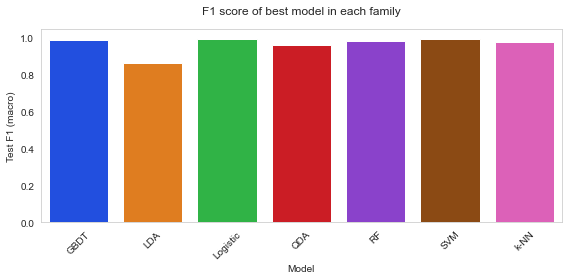

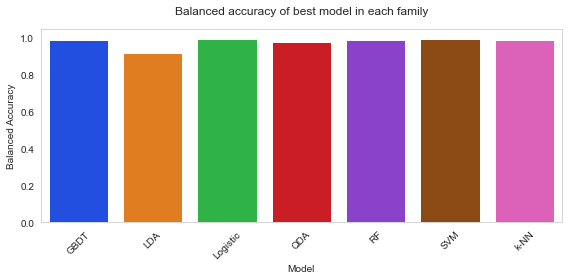

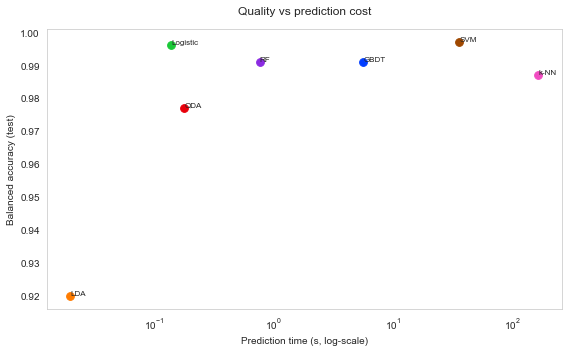

In [53]:
summary = t13_table.reset_index()

palette = sns.color_palette("bright", n_colors=len(summary))

#                           Barplot (F1 metric)- among best family models
# ====================================================================================================
fig1, ax1 = plt.subplots(figsize=(8, 4))
sns.barplot(x="Model", y="F1", data=summary, palette=palette, ax=ax1)
ax1.grid(False)
plt.xticks(rotation=45)
plt.ylabel("Test F1 (macro)")
plt.title("F1 score of best model in each family", pad=15)
plt.tight_layout()
fig1.savefig("barplot_f1_score.pdf", format="pdf", dpi=150, bbox_inches="tight")
plt.show()

#                            Barplot (balanced accuracy) - among best family models
# ====================================================================================================
fig2, ax2 = plt.subplots(figsize=(8, 4))
sns.barplot(x="Model", y="Bal. Acc", data=summary, palette=palette, ax=ax2)
ax2.grid(False)
plt.xticks(rotation=45)
plt.ylabel("Balanced Accuracy")
plt.title("Balanced accuracy of best model in each family", pad=15)
plt.tight_layout()
fig2.savefig("barplot_balanced_accuracy.pdf", format="pdf", dpi=150, bbox_inches="tight")
plt.show()

#                             Scatter plot "Predict time vs Balanced accuracy"
#                 shows the trade-off between predicted time and balanced accuracy metric 
# ====================================================================================================
fig3, ax3 = plt.subplots(figsize=(8, 5))
for i, row in summary.iterrows():
    ax3.scatter(
        row["Predict time (s)"],
        row["Bal. Acc"],
        color=palette[i],
        s=60
    )
    ax3.text(
        row["Predict time (s)"],
        row["Bal. Acc"],
        row["Model"],
        ha="left",
        va="bottom",
        fontsize=8
    )

ax3.set_xscale("log")
ax3.set_xlabel("Prediction time (s, log-scale)")
ax3.set_ylabel("Balanced accuracy (test)")
ax3.set_title("Quality vs prediction cost", pad=15)
ax3.grid(False)
plt.tight_layout()
fig3.savefig("scatter_quality_vs_cost.pdf", format="pdf", dpi=150, bbox_inches="tight")
plt.show()

#### Logistic Regression without PCA and SVM without PCA models show the best results. Closer look at these models

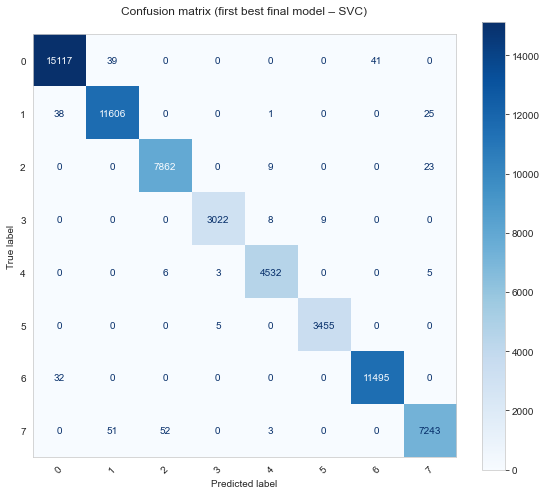

Classification report – first best model (SVC):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15197
           1       0.99      0.99      0.99     11670
           2       0.99      1.00      0.99      7894
           3       1.00      0.99      1.00      3039
           4       1.00      1.00      1.00      4546
           5       1.00      1.00      1.00      3460
           6       1.00      1.00      1.00     11527
           7       0.99      0.99      0.99      7349

    accuracy                           0.99     64682
   macro avg       0.99      0.99      0.99     64682
weighted avg       0.99      0.99      0.99     64682



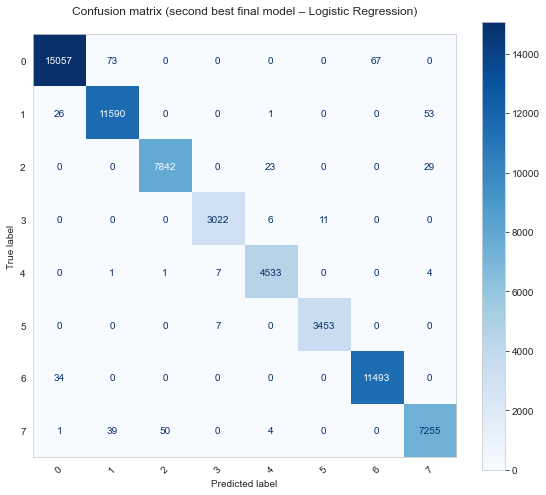

Classification report – second best model (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15197
           1       0.99      0.99      0.99     11670
           2       0.99      0.99      0.99      7894
           3       1.00      0.99      0.99      3039
           4       0.99      1.00      0.99      4546
           5       1.00      1.00      1.00      3460
           6       0.99      1.00      1.00     11527
           7       0.99      0.99      0.99      7349

    accuracy                           0.99     64682
   macro avg       0.99      0.99      0.99     64682
weighted avg       0.99      0.99      0.99     64682



In [54]:
#                 Confusion matrix and classification report for final models (SVC and Logistic)
# ================================================================================================================

first_best_final_model = models_dict["SVC"]
second_best_final_model = models_dict["Logistic_Regression"]

class_labels = sorted(np.unique(y_test))

# ---------------------------------------- 1) First best model (SVC) ----------------------------------------
y_test_pred_first = first_best_final_model.predict(X_test)
cm1 = confusion_matrix(y_test, y_test_pred_first)

fig1, ax1 = plt.subplots(figsize=(8, 7))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=class_labels)
disp1.plot(ax=ax1, cmap="Blues", xticks_rotation=45)
ax1.grid(False)

ax1.set_title("Confusion matrix (first best final model – SVC)", pad=20)
plt.tight_layout()
fig1.savefig("confusion_matrix_SVC.pdf", format="pdf", dpi=150, bbox_inches="tight")
plt.show()

print("Classification report – first best model (SVC):")
print(classification_report(y_test, y_test_pred_first, target_names=[str(c) for c in class_labels]))

# ---------------------------------------- 2) Second best model (Logistic Regression) ---------------------------
y_test_pred_second = second_best_final_model.predict(X_test)
cm2 = confusion_matrix(y_test, y_test_pred_second)

fig2, ax2 = plt.subplots(figsize=(8, 7))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=class_labels)
disp2.plot(ax=ax2, cmap="Blues", xticks_rotation=45)
ax2.grid(False)

ax2.set_title("Confusion matrix (second best final model – Logistic Regression)", pad=20)
plt.tight_layout()
fig2.savefig("confusion_matrix_LogisticRegression.pdf", format="pdf", dpi=150, bbox_inches="tight")
plt.show()

print("Classification report – second best model (Logistic Regression):")
print(classification_report(y_test, y_test_pred_second, target_names=[str(c) for c in class_labels]))

### Choosing the best model
1) SVC achieves slightly higher balanced accuracy, but the confusion structure is almost identical to Logistic Classification

2) both models rarely confuse classes and errors are concentrated in a few neighbouring classes

3) The models distinguish all 8 classes perfectly, without any obvious “problem” class.

4) Residual errors are logical: they arise between semantically close surface types.

Considering the almost identical confusion matrix and much shorter prediction time of **Logistic Regression**, it can be justified as the **“practical best choice”**, and **SVC** as the **“theoretical best in terms of balanced accuracy”**

### We choose Logistic Regression (without PCA)
**Why** this model? (even though SVC is formally slightly better in balanced accuracy)
- The quality difference is microscopic
- Balanced Accuracy and F1 for SVC and Logistic Regression match down to the hundredths
- The confusion matrices are practically identical: the same pairs of classes are confused with the same (very low) frequency
- Speed and scalability
- Prediction time for Logistic Regression is orders of magnitude lower than for SVC. This becomes critical if: the dataset grows, multiple scenes need to be processed, inference must run in real time or on limited hardware.
- Interpretability and simplicity (It is easy to inspect band weights and explain what the model considers important,it is simpler to debug and to re-fit
- Production logic

coefs shape: (8, 218)


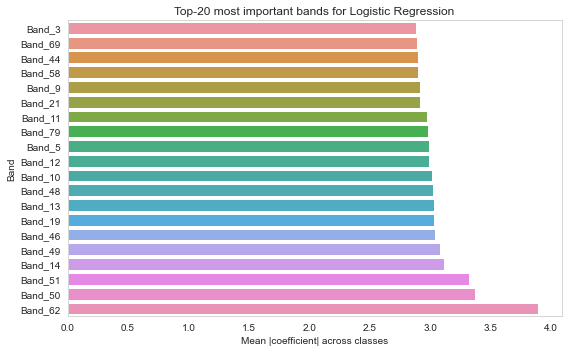

In [55]:
#                                Most important bands for Logistic Regression
# ================================================================================================================ 

logreg_pipe = models_dict["Logistic_Regression"]
logreg_clf = logreg_pipe.named_steps["logisticregression"]
assert isinstance(logreg_clf, LogisticRegression)

coefs = logreg_clf.coef_        
n_classes, n_features = coefs.shape
print("coefs shape:", coefs.shape)

mean_abs_importance = np.mean(np.abs(coefs), axis=0)

feat_imp = (pd.DataFrame({"feature": band_cols,            
                          "importance": mean_abs_importance}).sort_values("importance", ascending=False))

top_feat_imp = feat_imp.head(20).sort_values("importance", ascending=True)

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=top_feat_imp, x="importance", y="feature")
ax.grid(False)
plt.xlabel("Mean |coefficient| across classes")
plt.ylabel("Band")
plt.title(f"Top-20 most important bands for Logistic Regression")
plt.tight_layout()
plt.savefig("top20_bands_logreg.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

In [56]:
def mypredict():
    
    import pandas as pd
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression

    # reading data 
    df_test = pd.read_csv("test.csv.gz", compression="gzip")
    df_train = pd.read_csv("data-1.csv.gz", compression="gzip")

    # selecting bands
    band_cols = [c for c in df_train.columns if c.startswith("Band")]
    band_cols_test = [c for c in df_test.columns if c.startswith("Band")]

    X_train_full = df_train[band_cols].values
    y_train_full = df_train["land_type_cat"].values

    X_test_final = df_test[band_cols_test].values

    # building final model and fitting on ALL training data
    final_model = make_pipeline(StandardScaler(),
                                LogisticRegression(max_iter=3000, solver='lbfgs',
                                                   C=10, class_weight='balanced'))
    final_model.fit(X_train_full, y_train_full)

    # predicting
    y_pred_codes = final_model.predict(X_test_final)
    y_pred_codes = np.asarray(y_pred_codes).ravel()

    # mapping code → label 
    code_to_label = (df_train[['land_type_cat', 
                               'land_type']].drop_duplicates().set_index('land_type_cat')['land_type'].to_dict())

    y_pred_labels = [code_to_label[int(code)] for code in y_pred_codes]

    out_fname = "test_predictions.txt"
    with open(out_fname, "w") as f:
        for lbl in y_pred_labels:
            f.write(lbl + "\n")

    return out_fname


# **T 1.4: GLACIER-ICE DETECTION**

Glacier: influence of the size of the TRAINING sample on F2 (glacier class)

Model: Bagging
  Size    1000: F2_test=0.9428, F2_train=0.9774, Overfit=0.0346, Time=1.9s
  Size    2000: F2_test=0.9311, F2_train=0.9699, Overfit=0.0387, Time=0.3s
  Size    5000: F2_test=0.9582, F2_train=1.0000, Overfit=0.0418, Time=0.4s
  Size    8000: F2_test=0.9717, F2_train=0.9944, Overfit=0.0226, Time=0.6s
  Size   10000: F2_test=0.9713, F2_train=1.0000, Overfit=0.0287, Time=0.7s
  Size   15000: F2_test=0.9759, F2_train=0.9988, Overfit=0.0228, Time=1.1s
  Size   20000: F2_test=0.9756, F2_train=0.9974, Overfit=0.0218, Time=1.4s

Model: AdaBoost
  Size    1000: F2_test=0.9525, F2_train=1.0000, Overfit=0.0475, Time=0.6s
  Size    2000: F2_test=0.9520, F2_train=1.0000, Overfit=0.0480, Time=1.3s
  Size    5000: F2_test=0.9780, F2_train=1.0000, Overfit=0.0220, Time=3.1s
  Size    8000: F2_test=0.9704, F2_train=1.0000, Overfit=0.0296, Time=4.8s
  Size   10000: F2_test=0.9787, F2_train=1.0000, Overfit=0.0213, T

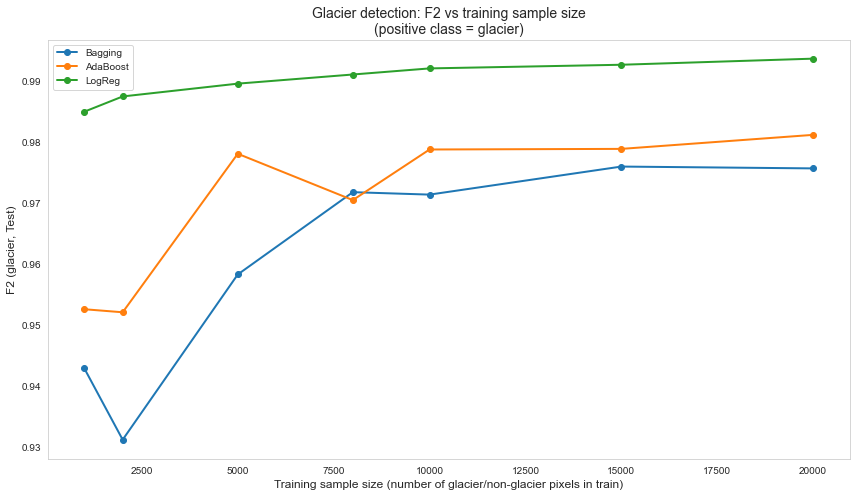

In [62]:
# ---------------------------------------------------------------------------------------------------------------
#                               QUICK understanding of optimal train sample size: F2-score
# ---------------------------------------------------------------------------------------------------------------
BETA = 2.0

models_glacier = {"Bagging": BaggingClassifier(random_state=random_state, n_jobs=-1),
                  "AdaBoost": AdaBoostClassifier(random_state=random_state),
                  "LogReg": make_pipeline(StandardScaler(),
                                          LogisticRegression(max_iter=3000,
                                                             class_weight="balanced",   # чуть компенсируем редкий glacie
                                                             random_state=random_state)
                                         )
                 }

def glacier_sample_size_test(X_train_glac, y_train_glac,
                             X_test_glac, y_test_glac,
                             train_sizes, random_state=random_state):
    """
    Quick_performance_test:
    - binary task glacier / non-glacier
    - goal metric: F_beta (beta=2) for glacier calss (label=1)
    - no parameter tuning at this step
    """

    results = []

    available_train_sizes = [s for s in train_sizes if s <= len(X_train_glac)]

    print("=" * 80)
    print("Glacier: influence of the size of the TRAINING sample on F2 (glacier class)")
    print("=" * 80)

    for model_name, model in models_glacier.items():
        print(f"\n{'='*40}")
        print(f"Model: {model_name}")
        print(f"{'='*40}")

        for train_size in available_train_sizes:

            # stratified subsample
            X_sample, _, y_sample, _ = train_test_split(X_train_glac, y_train_glac,
                                                        train_size=train_size,
                                                        stratify=y_train_glac,
                                                        random_state=random_state)
            # fitting time
            t0 = time.time()
            model.fit(X_sample, y_sample)
            fit_time = time.time() - t0

            # predict on test
            t0 = time.time()
            y_test_pred = model.predict(X_test_glac)
            pred_time = time.time() - t0

            # F2 test
            f2_test = fbeta_score(y_test_glac, y_test_pred,
                                      beta=BETA, pos_label=1)

            # F2 train 
            y_train_pred = model.predict(X_sample)
            f2_train = fbeta_score(y_sample, y_train_pred,
                                       beta=BETA, pos_label=1)

            overfit_gap = f2_train - f2_test
            bal_acc = balanced_accuracy_score(y_test_glac, y_test_pred)

            results.append({"Model": model_name,
                            "Train Size": train_size,
                            "Fit Time (s)": round(fit_time, 2),
                            "Pred Time (s)": round(pred_time, 4),
                            f"F{BETA:g} Train": round(f2_train, 4),
                            f"F{BETA:g} Test": round(f2_test, 4),
                            "Overfit Gap": round(overfit_gap, 4),
                            "Balanced Acc": round(bal_acc, 4)})

            print(f"  Size {train_size:>7}: "
                      f"F{BETA:g}_test={f2_test:.4f}, "
                      f"F{BETA:g}_train={f2_train:.4f}, "
                      f"Overfit={overfit_gap:.4f}, "
                      f"Time={fit_time:.1f}s")
    return pd.DataFrame(results)

    
def plot_glacier_sample_size_results(df_results, filename="glacier_sample_size_performance.pdf"):
    """
    Visualisation: F2 (Test) vs Train Size for every model
    """
    plt.figure(figsize=(12, 7))

    for model in df_results["Model"].unique():
        sub = df_results[df_results["Model"] == model].sort_values("Train Size")
        plt.plot(sub["Train Size"],
                 sub[f"F{BETA:g} Test"],
                 marker="o",
                 linewidth=2,
                 label=model)

    plt.xlabel("Training sample size (number of glacier/non-glacier pixels in train)", fontsize=12)
    plt.ylabel(f"F{BETA:g} (glacier, Test)", fontsize=12)
    plt.title(f"Glacier detection: F{BETA:g} vs training sample size\n(positive class = glacier)", fontsize=14)
    plt.legend()
    
    ax = plt.gca()
    ax.grid(False)
    
    plt.tight_layout()

    plt.savefig(filename, format="pdf", dpi=300, bbox_inches="tight")
    print(f"Plot saved '{filename}'")

    plt.show()
    
    
train_sizes_glacier = [1000, 2000, 5000, 8000, 10000, 15000, 20000]

df_glacier_perf = glacier_sample_size_test(X_train_glac, y_train_glac,
                                           X_test_glac, y_test_glac,
                                           train_sizes=train_sizes_glacier,
                                           random_state=random_state)

df_glacier_perf.to_csv("glacier_sample_size_performance.csv", index=False)
print("\nResults saved to 'glacier_sample_size_performance.csv'")

plot_glacier_sample_size_results(df_glacier_perf)

In [63]:
### 10k tuning sample -> 70% fitting with best parameters

### glacier ice = positive, others = negative
df['is_glacier'] = df['land_type'].apply(lambda x : 1 if x == 'snow / ice' else 0)

X_glac = df[band_cols].values
y_glac = df["is_glacier"].astype(int).values   # 1 = glacier, 0 = non-glacier

print("Positive class proportion (glacier):", y_glac.mean())

#                                                 Sampling
# ================================================================================================================ 

# Train / Test split (70/30, stratified)
X_train_glac, X_test_glac, y_train_glac, y_test_glac = train_test_split(X_glac,
                                                                        y_glac, 
                                                                        test_size=0.3,
                                                                        stratify=y_glac,
                                                                        random_state=random_state)
print(X_train_glac.shape, X_test_glac.shape)

# stratified sample of 10k
X_tune_glac, _, y_tune_glac, _ = train_test_split(X_train_glac,
                                                  y_train_glac,
                                                  train_size=10000,
                                                  stratify=y_train_glac,
                                                  random_state=random_state)
print(X_tune_glac.shape, X_train_glac.shape)
    
#                                       Goal metric: F_beta for glacier
# ================================================================================================================ 
BETA = 2.0  # F2-score (glacier class is rare, we decided to penalise FN outcomes more than in F1-score) 

fbeta_glacier_scorer = make_scorer(fbeta_score,
                                   beta=BETA,
                                   pos_label=1,
                                   average="binary")


#                                                    Modeling
# ================================================================================================================ 
# 1) Bagging
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, random_state=random_state),
                        n_jobs=-1,
                        random_state=random_state)

param_grid_bag = {"n_estimators": [50, 100, 200],
                  "max_samples": [0.5, 0.7, 1.0]}

# 2) AdaBoost
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, random_state=random_state),
                         random_state=random_state)

param_grid_ada = {"n_estimators": [100, 200, 300],
                  "learning_rate": [0.05, 0.1, 0.2]}

# 3) LogReg
log = make_pipeline(StandardScaler(),
                        LogisticRegression(max_iter=3000, class_weight="balanced", random_state=random_state))

param_grid_log = {"logisticregression__C": [0.1, 1, 10, 100],
                  "logisticregression__penalty": ['l1', 'l2', 'elasticnet', None],
                 "logisticregression__solver": ['lbfgs', 'liblinear', 'saga']}

Positive class proportion (glacier): 0.05349158642696796
(150922, 218) (64682, 218)
(10000, 218) (150922, 218)


In [64]:
def fit_and_evaluate_glacier(model,param_grid,X_tune, y_tune, 
                             X_train_full, y_train_full, 
                             X_test, y_test, name="model"):
    """
        GridSearchCV for F_beta on the X_tune, y_tune subset, 
        then final training of the best model on the entire train set
        and quality assessment on the test set
    """

    gs = GridSearchCV(estimator=model,
                      param_grid=param_grid,
                      scoring=fbeta_glacier_scorer,
                      cv=5,
                      n_jobs=-1,
                      verbose=2)
    gs.fit(X_tune, y_tune) # cv on 10k -> choosing the best parameters
    
    
    best_model = gs.best_estimator_
    print(f"{name}: best params (on subsample) =", gs.best_params_)
    best_model.fit(X_train_full, y_train_full) # fitting the model on all 70% of the data with the best parameters

    # predictions on test
    y_pred = best_model.predict(X_test)

    if hasattr(best_model, "predict_proba"):
        scores = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        scores = best_model.decision_function(X_test)
    else:
        scores = None

    metrics = {"Model": name,
               f"F{BETA:g}_glacier": fbeta_score(y_test, y_pred, beta=BETA, pos_label=1),
               "F1_glacier": fbeta_score(y_test, y_pred, beta=1.0, pos_label=1),
               "Recall_glacier": recall_score(y_test, y_pred, pos_label=1),
               "Precision_glacier": precision_score(y_test, y_pred, pos_label=1),
               "Balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
               "Accuracy": accuracy_score(y_test, y_pred)
              }

    if scores is not None:
        try:
            metrics["ROC_AUC"] = roc_auc_score(y_test, scores)
            metrics["Average_precision"] = average_precision_score(y_test, scores)
        except ValueError:
            metrics["ROC_AUC"] = np.nan
            metrics["Average_precision"] = np.nan
    else:
        metrics["ROC_AUC"] = np.nan
        metrics["Average_precision"] = np.nan

    return best_model, metrics, scores, y_pred


In [65]:
results_t14 = []
artifacts_t14 = {}

# Bagging
bag_best, bag_metrics, bag_scores, bag_pred = fit_and_evaluate_glacier(bag, param_grid_bag,
                                                                       X_tune_glac, y_tune_glac,
                                                                       X_train_glac, y_train_glac,
                                                                       X_test_glac, y_test_glac,
                                                                       name="Bagging")
results_t14.append(bag_metrics)
artifacts_t14["Bagging"] = (bag_best, bag_scores, bag_pred)

# AdaBoost
ada_best, ada_metrics, ada_scores, ada_pred = fit_and_evaluate_glacier(ada, param_grid_ada,
                                                                       X_tune_glac, y_tune_glac,
                                                                       X_train_glac, y_train_glac,
                                                                       X_test_glac, y_test_glac,
                                                                       name="AdaBoost")
results_t14.append(ada_metrics)
artifacts_t14["AdaBoost"] = (ada_best, ada_scores, ada_pred)

# LogReg
log_best, log_metrics, log_scores, log_pred = fit_and_evaluate_glacier(log, param_grid_log,
                                                                       X_tune_glac, y_tune_glac,           
                                                                       X_train_glac, y_train_glac,
                                                                       X_test_glac, y_test_glac,
                                                                       name="LogReg")
results_t14.append(log_metrics)
artifacts_t14["LogReg"] = (log_best, log_scores, log_pred)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.9min finished


Bagging: best params (on subsample) = {'max_samples': 0.7, 'n_estimators': 100}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.7min finished


AdaBoost: best params (on subsample) = {'learning_rate': 0.2, 'n_estimators': 100}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.0min finished


LogReg: best params (on subsample) = {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}


In [66]:
t14_summary = (pd.DataFrame(results_t14).set_index("Model").round(3))
display(t14_summary)

,F2_glacier,F1_glacier,Recall_glacier,Precision_glacier,Balanced_accuracy,Accuracy,ROC_AUC,Average_precision
Model,,,,,,,,
Bagging,0.984,0.985,0.983,0.987,0.991,0.998,1.0,0.999
AdaBoost,0.991,0.991,0.991,0.991,0.995,0.999,1.0,1.000
LogReg,0.998,0.995,1.000,0.990,1.000,0.999,1.0,1.000


### Best model = LogRegression

Best model for glacier F_2: LogReg


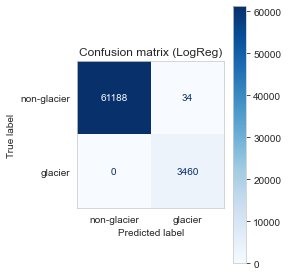

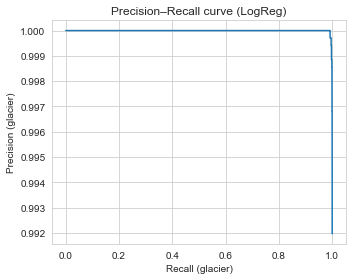

In [67]:
# F_2(glacier) best model
best_name = t14_summary[f"F{BETA:g}_glacier"].idxmax()
print("Best model for glacier F_2:", best_name)

best_model, best_scores, best_pred = artifacts_t14[best_name]

# Confusion matrix
cm = confusion_matrix(y_test_glac, best_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-glacier", "glacier"])

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap="Blues")
ax.grid(False)
ax.set_title(f"Confusion matrix ({best_name})")
plt.tight_layout()
plt.savefig("confusion_glacier_logistic.pdf", dpi=300, bbox_inches='tight')
plt.show()

# PR-кривая (если есть скоры)
if best_scores is not None:
    prec, rec, thr = precision_recall_curve(y_test_glac, best_scores)

    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec)
    plt.xlabel("Recall (glacier)")
    plt.ylabel("Precision (glacier)")
    plt.title(f"Precision–Recall curve ({best_name})")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("pr_curve_glacier_logistic.pdf", dpi=300, bbox_inches='tight')
    plt.show()